In [ ]:
import os
import sys
import json
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib widget

main_path = os.path.abspath(r'..\..')

sys.path.insert(0, main_path)
import AetheriaPackage.tail_plotter_tools as tpt

# save directory with all optimizations
results_path = os.path.join(main_path, r'output\_beta_sensitivity_7\COBYLA')

'''
columns: [ Class | Categoray | Unit | Alias (optional) ]

'''
study_var_vanilla = [
             ['Wing', 'aspect_ratio', '-'],
             ['Wing', 'surface', r'$m^2$', 'wing_surface'],
             ['Wing', 'span', 'm'],
             ['Fuselage', 'length_fuselage', 'm'],
             ['Fuselage', 'beta_crash', '-'],
             ['Fuselage', 'length_tail', 'm'],
             ['Fuselage', 'length_tank', 'm'],
             ['Fuselage', 'height_fuselage_outer', 'm'],
             ['Fuselage', 'height_fuselage_inner', 'm'],
             ['Fuselage', 'width_fuselage_inner', 'm'],
             ['Fuselage', 'width_fuselage_outer', 'm'],
             ['Fuselage', 'tank_radius', 'm'],
             ['Fuselage', 'volume_powersys', r'$m^3$'],
             ['Fuselage', 'bc', 'm'],
             ['Fuselage', 'hc', 'm'],
             ['Fuselage', 'bf', 'm'],
             ['Fuselage', 'hf', 'm'],
             ['AircraftParameters', 'MTOM', 'Kg'],
             ['AircraftParameters', 'mission_energy', 'J'],
             ['AircraftParameters', 'mission_time', 's'],
             ['AircraftParameters', 'max_thrust', 'N'],
             ['AircraftParameters', 'TW_max', '-'],
             ['AircraftParameters', 'OEM', 'Kg'],
             ['AircraftParameters', 'wing_loading_cruise', 'N/m'],
             ['Wing', 'x_lewing', 'm'], # position of LEMAC of main wing relative to nose of ac
             ['Veetail', 'length_wing2vtail', 'm'], # position of LEMAC of veetail relative to LEMAC of main wing
             ['Veetail', 'surface', r'$m^2$', 'veetail_surface'],
             ['Wing', 'wing_weight', 'Kg', 'wing_mass'],
             ['Veetail', 'vtail_weight', 'Kg', 'vtail_mass'],
             ['Fuselage', 'fuselage_weight', 'Kg', 'fuselage_mass'],
             ['AircraftParameters', 'misc_mass', 'Kg'],
             ['AircraftParameters', 'lg_mass', 'Kg', 'landing_gear_mass'],
             ['Power', 'cooling_mass', 'Kg'],
             ['Power', 'h2_tank_mass', 'Kg'],
             ['Power', 'powersystem_mass', 'Kg'],
             ['Power', 'fuelcell_mass', 'Kg'],
             ['Power', 'battery_mass', 'Kg'],
             ['Engine', 'totalmass', 'Kg', 'engines_mass']
             ]

study_var_new = [
             ['Wing', 'aspect_ratio', '-'],
             ['Wing', 'surface', r'$m^2$', 'wing_surface'],
             ['Wing', 'span', 'm'],
             ['Fuselage', 'length_fuselage', 'm'],
             ['Fuselage', 'beta_crash', '-'],
             ['Fuselage', 'length_tail', 'm'],
             ['Fuselage', 'wetted_area', 'm2'],
             ['Power', 'h2_tank_length', 'm'],
             ['Fuselage', 'height_fuselage_outer', 'm'],
             ['Fuselage', 'height_fuselage_inner', 'm'],
             ['Fuselage', 'width_fuselage_inner', 'm'],
             ['Fuselage', 'width_fuselage_outer', 'm'],
             ['Power', 'h2_tank_radius', 'm'],
             ['Power', 'h2_tank_volume', r'$m^3$'],
             ['Fuselage', 'bc', 'm'],
             ['Fuselage', 'hc', 'm'],
             ['Fuselage', 'bf', 'm'],
             ['Fuselage', 'hf', 'm'],
             ['AircraftParameters', 'MTOM', 'Kg'],
             ['AircraftParameters', 'mission_energy', 'J'],
             ['AircraftParameters', 'mission_time', 's'],
             ['AircraftParameters', 'max_thrust', 'N'],
             ['AircraftParameters', 'TW_max', '-'],
             ['AircraftParameters', 'OEM', 'Kg'],
             ['AircraftParameters', 'wing_loading_cruise', 'N/m'],
             ['Wing', 'x_lewing', 'm'], # position of LEMAC of main wing relative to nose of ac
             ['Veetail', 'length_wing2vtail', 'm'], # position of LEMAC of veetail relative to LEMAC of main wing
             ['Veetail', 'surface', r'$m^2$', 'veetail_surface'],
             ['Wing', 'wing_weight', 'Kg', 'wing_mass'],
             ['Veetail', 'vtail_weight', 'Kg', 'vtail_mass'],
             ['Fuselage', 'fuselage_weight', 'Kg', 'fuselage_mass'],
             ['AircraftParameters', 'misc_mass', 'Kg'],
             ['AircraftParameters', 'lg_mass', 'Kg', 'landing_gear_mass'],
             ['Power', 'cooling_mass', 'Kg'],
             ['Power', 'h2_tank_mass', 'Kg'],
             ['Power', 'powersystem_mass', 'Kg'],
             ['Power', 'fuelcell_mass', 'Kg'],
             ['Power', 'battery_mass', 'Kg'],
             ['Engine', 'totalmass', 'Kg', 'engines_mass']
             ]

if '_beta_sensitivity_2' in results_path: study_var = list(study_var_vanilla)
else: study_var = list(study_var_new)

# generate aliases
for i, var in enumerate(study_var):
    if len(var) != 4:
        study_var[i].append(var[1])

In [6]:
def search_json(dir, search_term, save_lst=list([])):
    for f in os.listdir(dir):
        if os.path.isdir(os.path.join(dir, f)):
            search_json(os.path.join(dir, f), search_term, save_lst)
        elif os.path.splitext(f)[-1] == '.json' and search_term in f:
            save_lst.append(os.path.join(dir, f))
    
    return save_lst

In [7]:
# extracting data into pandas DataFrame

data_files = search_json(results_path, 'design')
n_ac = len(data_files)
study_data = {}

for var in study_var:
    study_data[var[3]] = list([])


for file_path in data_files:
    with open(file_path, 'r') as f:
        all_data = json.load(f)

    for var in study_var:
        study_data[var[3]].append(all_data[var[0]][var[1]])

study_data = pd.DataFrame(study_data)

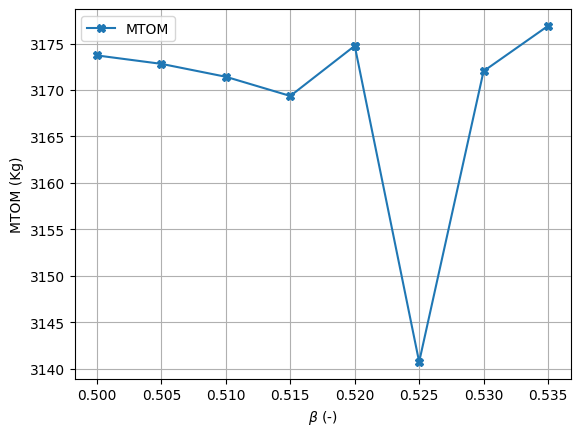

In [8]:
# plot a single beta graph

tar_var_lst = ['MTOM']
# search for units
tar_unit_lst = []
for tar_var in tar_var_lst:
    for var_lst in study_var:
        if tar_var in var_lst: tar_unit_lst.append(var_lst[2])

# var = 'x_LEMAC_veetail'
plt.plot(study_data['beta_crash'], study_data[tar_var_lst[0]], label=tar_var_lst[0], marker='X')
# # plt.plot(study_data['beta_crash'], study_data[tar_var_lst[2]], label='length_fuselage')
plt.xlabel(r'$\beta$ (-)')
plt.ylabel(rf'MTOM ({tar_unit_lst[0]})')
plt.legend()
plt.grid()
plt.savefig(rf'beta_plots//{dt.datetime.now():%m-%d} - beta-surfaces.png')
# plt.xlim((0.52, 0.535))

## Interesting Graphs

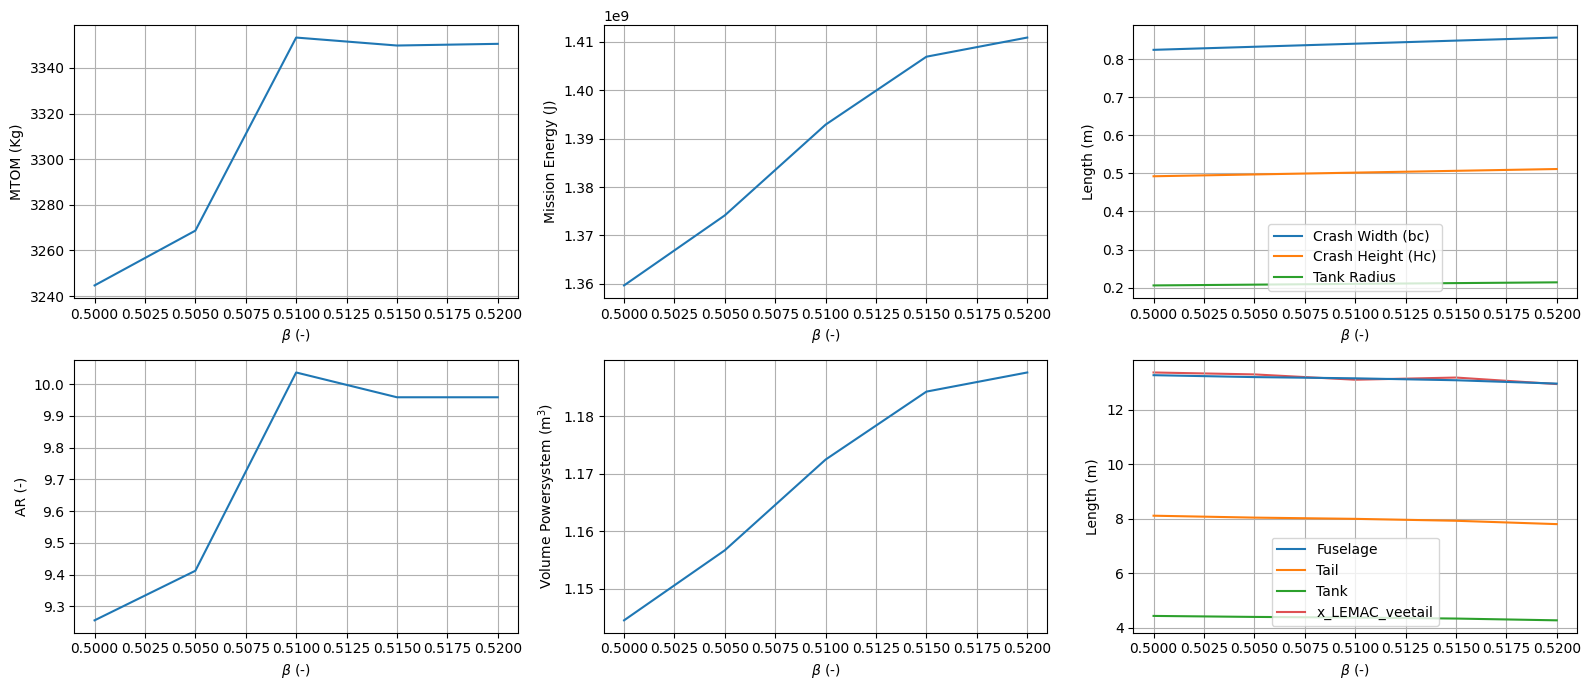

In [13]:
# plotting interesting beta graphs
'''
interesting figures
- MTOM
- aspect ratio
- mission_energy
- surface
- volume_powersys
- bc, hc, tank_radius
- length_fuselage, length_tail, length_tank

- mission_time (follows trend of aspect_ratio)
- max_thrust (follows trend of MTOM, as TW_max is constant)
- surface (follows trend of MTOM, as wing loading const)
- span (follows trend of aspect_ratio)
'''

fig, axs = plt.subplots(2, 3, figsize=(16,7))
opt_lim = {'MTOM': 3175, 'length_fuselage': 14, 'AR': [5, 15]}
overlay_constraints = False

b_min = np.min(study_data['beta_crash'])
b_max = np.max(study_data['beta_crash'])

ax = axs[0, 0]
ax.plot(study_data['beta_crash'], study_data['MTOM'])
if overlay_constraints:
    ax.hlines(opt_lim['MTOM'], b_min, b_max, ls='--', color='red', alpha=0.7)
    ax.text( 0.00*(b_max-b_min)+b_min, opt_lim['MTOM'], 'MTOM constraint', color='red')
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'MTOM (Kg)')
ax.grid()

ax = axs[1, 0]
ax.plot(study_data['beta_crash'], study_data['aspect_ratio'])
if overlay_constraints:
    ax.hlines(opt_lim['AR'][0], b_min, b_max, ls='--', color='red', alpha=0.7)
    ax.text( 0.00*(b_max-b_min)+b_min, opt_lim['AR'][0], 'AR constraint', color='red')
    ax.hlines(opt_lim['AR'][1], b_min, b_max, ls='--', color='red', alpha=0.7)
    ax.text( 0.00*(b_max-b_min)+b_min, opt_lim['AR'][1], 'AR constraint', color='red')
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'AR (-)')
ax.grid()

ax = axs[0, 1]
ax.plot(study_data['beta_crash'], study_data['mission_energy'])
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'Mission Energy (J)')
ax.grid()

ax = axs[1, 1]
ax.plot(study_data['beta_crash'], study_data['h2_tank_volume']) #volume_powersys
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'Volume Powersystem (m$^3$)')
ax.grid()

ax = axs[0, 2]
ax.plot(study_data['beta_crash'], study_data['bc'], label='Crash Width (bc)')
ax.plot(study_data['beta_crash'], study_data['hc'], label='Crash Height (Hc)')
ax.plot(study_data['beta_crash'], study_data['h2_tank_radius'], label='Tank Radius') #tank_radius
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'Length (m)')
ax.legend()
ax.grid()

ax = axs[1, 2]
ax.plot(study_data['beta_crash'], study_data['length_fuselage'], label='Fuselage')
if overlay_constraints:
    ax.hlines(opt_lim['length_fuselage'], b_min, b_max, ls='--', color='red', alpha=0.7)
    ax.text(0.60*(b_max-b_min)+b_min, opt_lim['length_fuselage'], 'fuselage constraint', color='red')
ax.plot(study_data['beta_crash'], study_data['length_tail'], label='Tail')
ax.plot(study_data['beta_crash'], study_data['h2_tank_length'], label='Tank') #length_tank
ax.plot(study_data['beta_crash'], study_data['x_lewing']+study_data['length_wing2vtail'], label='x_LEMAC_veetail', alpha=0.8, zorder=1.5)
ax.set_xlabel(r'$\beta$ (-)')
ax.set_ylabel(r'Length (m)')
ax.legend()
ax.grid()

fig.tight_layout()

# plt.savefig(rf'beta_plots\\{dt.datetime.now():%m-%d} - plots of interest (wo bounds) 2.png', dpi=300)


## Mass Distribution Graphs

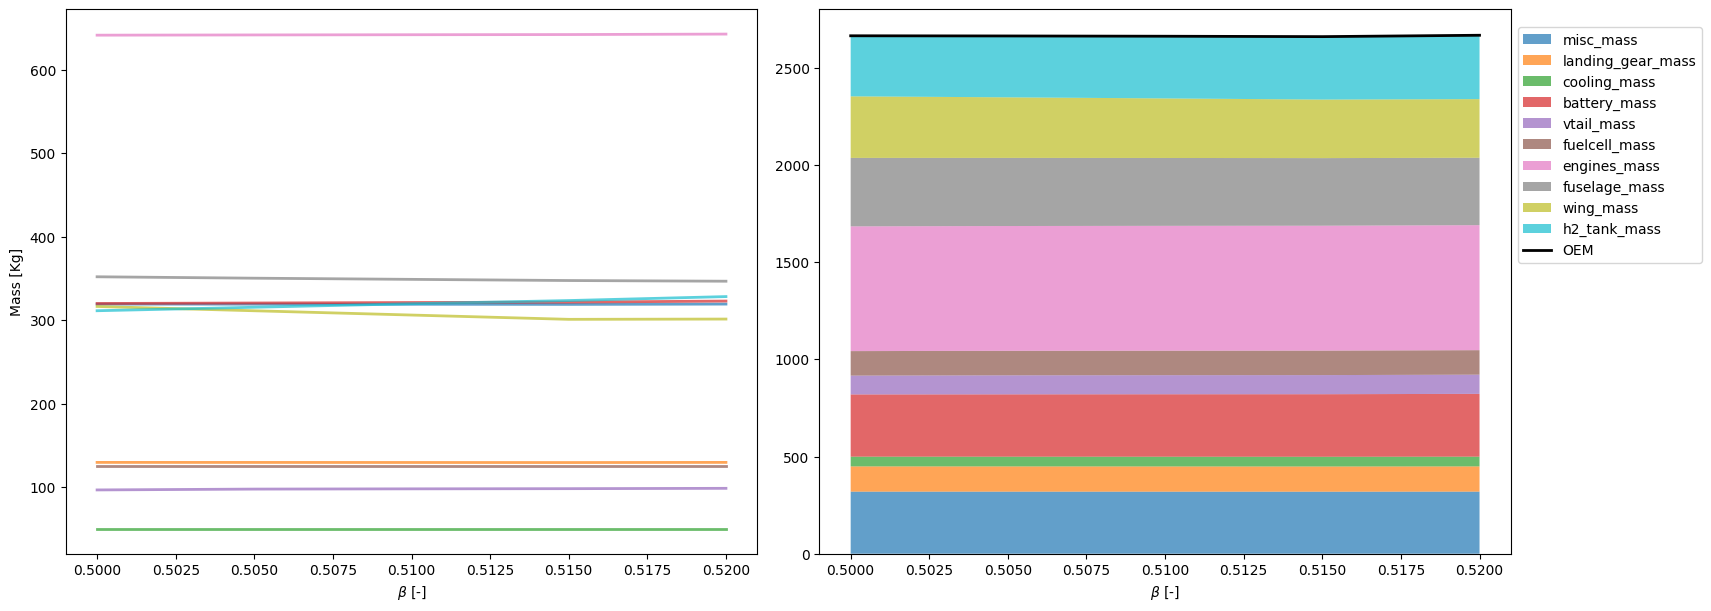

In [6]:
# plotting mass-related graphs

mass_components_name = [
                   'misc_mass',
                   'landing_gear_mass',
                   'cooling_mass',
                   'battery_mass', 
                   'vtail_mass',
                   'fuelcell_mass',
                   'engines_mass', 
                   'fuselage_mass', 
                   'wing_mass', 
                   'h2_tank_mass',
                   ]

normalise = False

fig, ax = plt.subplots(1, 2, figsize=(17,6),layout="constrained")


if normalise:
    factor = study_data['OEM']
    ax[0].set_ylabel(r'Normalised Mass (wrt. OEM) [Kg/Kg]')
else: 
    factor = np.ones(np.shape(study_data['OEM']))
    ax[0].set_ylabel(r'Mass [Kg]')

ax[0].set_xlabel(r'$\beta$ [-]')
ax[1].set_xlabel(r'$\beta$ [-]')

mass_components = np.array([study_data[i]/factor for i in mass_components_name])

# plot only individual lines on the left axes
for m, name in enumerate(mass_components_name):
    ax[0].plot(study_data['beta_crash'], mass_components[m], alpha=0.7, label=name, lw=2)

# plot stacked lines on the right axes
ax[1].stackplot(study_data['beta_crash'], mass_components, alpha=0.7, labels=mass_components_name)
ax[1].plot(study_data['beta_crash'], study_data['OEM']/factor, color='black', lw=2, label='OEM')

lgd = ax[1].legend(bbox_to_anchor=(1, 0.98), loc='upper left')
plt.savefig(rf'beta_plots\\{dt.datetime.now():%m-%d %H.%M} - OEM distribution norm={normalise}.png',
            dpi=700, bbox_extra_artists=(lgd,), bbox_inches='tight')


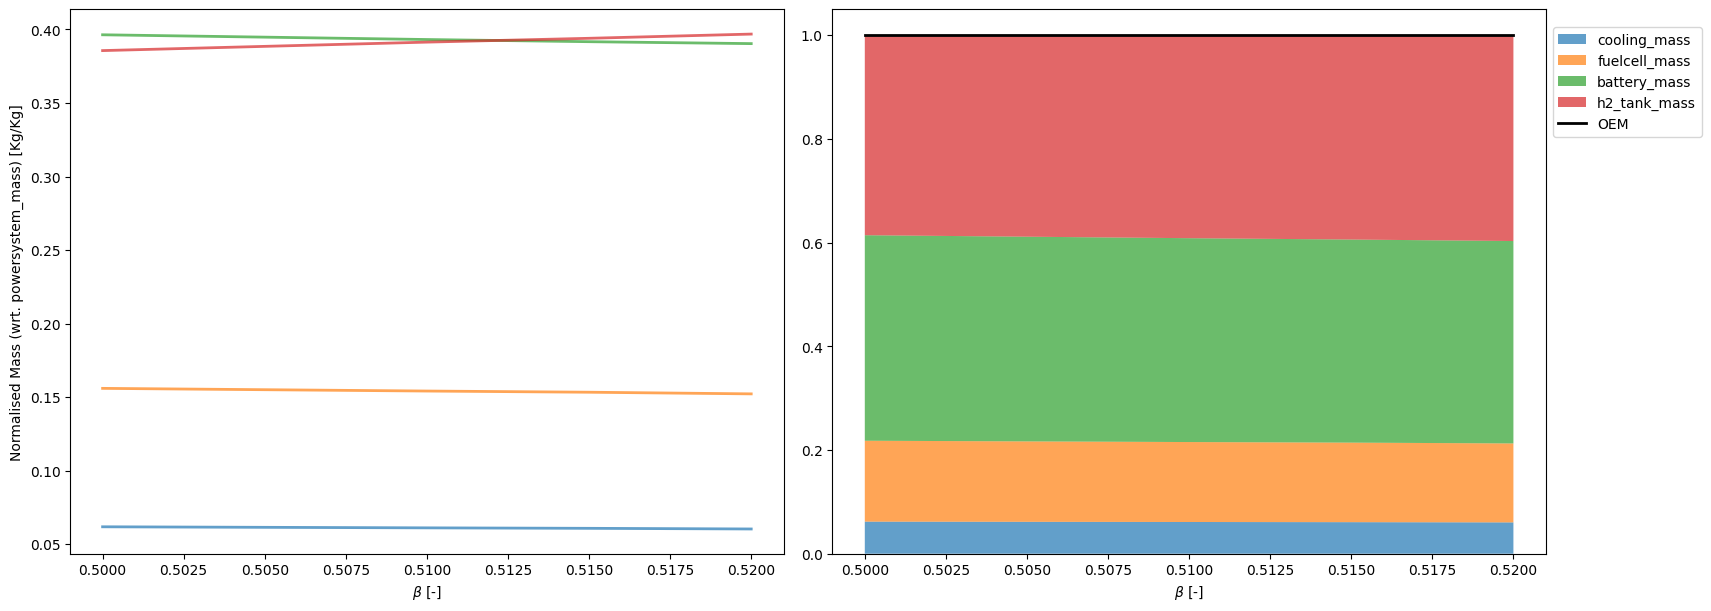

In [7]:
# plotting mass-related graphs (powersystem only)

mass_components_name = [
                   'cooling_mass',
                   'fuelcell_mass',
                   'battery_mass', 
                   'h2_tank_mass',
                   ]

normalise = True

fig, ax = plt.subplots(1, 2, figsize=(17,6),layout="constrained")


if normalise: 
    factor = study_data['powersystem_mass']
    ax[0].set_ylabel(r'Normalised Mass (wrt. powersystem_mass) [Kg/Kg]')
else:
    factor = np.ones(np.shape(study_data['powersystem_mass']))
    ax[0].set_ylabel(r'Mass [Kg]')

ax[0].set_xlabel(r'$\beta$ [-]')
ax[1].set_xlabel(r'$\beta$ [-]')

mass_components = np.array([study_data[i]/factor for i in mass_components_name])

# plot only individual lines on the left axes
for m, name in enumerate(mass_components_name):
    ax[0].plot(study_data['beta_crash'], mass_components[m], alpha=0.7, label=name, lw=2)

# plot stacked lines on the right axes
ax[1].stackplot(study_data['beta_crash'], mass_components, alpha=0.7, labels=mass_components_name)
ax[1].plot(study_data['beta_crash'], study_data['powersystem_mass']/factor, color='black', lw=2, label='OEM')

lgd = ax[1].legend(bbox_to_anchor=(1, 0.98), loc='upper left')
plt.savefig(rf'beta_plots\\{dt.datetime.now():%m-%d %H.%M} - powersystem mass distribution norm={normalise}.png',
            dpi=700, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plotting Everthing

In [ ]:
# plotting each tail

if not os.path.exists('tail_plots'):
    os.mkdir('tail_plots')

for i in range(n_ac):
    ac = study_data.loc[i]
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(rf'$\beta$={ac['beta_crash']}')

    tpt.plot_complete_tail(l_tail=ac['length_tail'],
                           l_tank=ac['length_tank'],
                           h0=ac['height_fuselage_inner'],
                           b0=ac['width_fuselage_inner'],
                           hc=ac['hc'],
                           bc=ac['bc'],
                           bf=ac['bf'],
                           hf=ac['hf'],
                           r_tank=ac['tank_radius'],
                           linear_rel='AR',
                           ax=ax)
    plt.savefig(rf'tail_plots//{dt.datetime.now():%m-%d} - beta={ac['beta_crash']}.png', dpi=300)
    # plt.clf()
    


In [ ]:
# plotting all beta graphs

if not os.path.exists('beta_plots'):
    os.mkdir('beta_plots')

for (cvar, var, unit) in study_var:
    if var == 'beta_crash': continue
    
    plt.plot(study_data['beta_crash'], study_data[var])
    plt.xlabel(r'$\beta$ (-)')
    plt.ylabel(rf'{var} ({unit})')
    plt.grid()

    plt.savefig(rf'beta_plots//{dt.datetime.now():%m-%d} - beta-{var}.png', dpi=300)
    # plt.show()
    plt.clf()